TorchSDE
https://github.com/google-research/torchsde

Hiraiwa Model
https://link.aps.org/doi/10.1103/PhysRevLett.125.268104

In [1]:
!pip install torchsde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.7/193.7 KB 29.6 MB/s eta 0:00:00
You should consider upgrading via the '/home/uwamichi/.pyenv/versions/3.8.13/bin/python3.8 -m pip install --upgrade pip' command.


In [30]:
!pip install -U torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 58.2 MB/s eta 0:00:00m eta 0:00:010:00:01
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.8.1
    Uninstalling torchvision-0.8.1:
      Successfully uninstalled torchvision-0.8.1
You should consider upgrading via the '/home/uwamichi/.pyenv/versions/3.8.13/bin/python3.8 -m pip install --upgrade pip' command.


In [40]:
!pip install cupy-cuda111

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 MB 17.8 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 KB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 50.5 MB/s eta 0:00:00m eta 0:00:010:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
You should consider upgrading via the '/home/uwamichi/.pyenv/versions/3.8.13/bin/python3.8 -m pip install --upgrade pip' command.


In [1]:
!pip list

Package                           Version     Editable project location
--------------------------------- ----------- -------------------------------------
anyio                             3.6.1
argon2-cffi                       21.3.0
argon2-cffi-bindings              21.2.0
asttokens                         2.0.5
attrs                             21.4.0
Babel                             2.10.3
backcall                          0.2.0
beautifulsoup4                    4.11.1
bleach                            5.0.0
boltons                           21.0.0
certifi                           2022.6.15
cffi                              1.15.0
charset-normalizer                2.0.12
cupy-cuda111                      11.0.0
cvxopt                            1.3.0
cycler                            0.11.0
dataclasses                       0.6
debugpy                           1.6.0
decorator                         5.1.1
defusedxml                        0.7.1
entrypoints                     

dy(t) = f(t, y(t)) dt + g(t, y(t)) dW(t) 

y(t0) = y0 

In [2]:
import numpy as np
import torch
from torch import nn
from torchsde import BrownianInterval, sdeint
import matplotlib.pyplot as plt
from ipywidgets import interact

In [3]:
from scipy import special
from torch.autograd import Function

In [4]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(torch.device('cuda:0')))
print(torch.cuda.get_device_name(torch.device('cuda:1')))

2
NVIDIA TITAN V
NVIDIA GeForce GTX 1080


In [5]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# nondimensionalize by setting 1
v0 = 1.0
r = 1.0

# fixed noise strength (0.1 in article)
D = 0.1

# external directional bias (0 or 0.1 in article)
A = 0.0

# boundary conditions (L=100 in article)
L = 20
periodic = True

# particle density (1 in article)
rho = 1.0

# strength of excluded volume force (fixed at 1)
beta = 1.0

# strength of contact following, contact inhibition of locomotion
A_CF = 0.9
A_CIL = 0.0

# numbers of cells, freedom, and noise source
batch_size, state_size, brownian_size = int(rho*(L**2)), 3, 1

# duration of simulation (6400 in the article)
t_max =  1000

# method to solve SDE
methodSDE = 'heun'
isIto = False

# time step to simulate
stepSDE = 1e-2


In [6]:
kappa = 0.1
A_Macdonald = 1.4

In [7]:
class torch_knFunction(Function):
    @staticmethod
    def forward(ctx, input, n):
        numpy_input = input.cpu().detach().numpy()
        result = special.kn(n, numpy_input)
        return torch.as_tensor(result, dtype=input.dtype, device=device)
    
    @staticmethod
    def backward(ctx, grad_output):
        numpy_go = grad_output.cpu().detach().numpy()
        input, n = ctx.saved_tensors
        numpy_input = input.cpu().detach().numpy()
        if n==0:
            grad_kn = -special.kn(1, numpy_input)
        else:
            grad_kn = -(special.kn(n-1, numpy_input) + special.kn(n+1, numpy_input))/2
        result = numpy_go * grad_kn
        return torch.as_tensor(result, dtype=input.dtype, device=device)

class torch_kn(nn.Module):
    def __init__(self, n):
        super(torch_kn, self).__init__()
        self.n = n
        
    def forward(self, input):
        return torch_knFunction.apply(input, self.n)
    
torch_scipy_k0 = torch_kn(0)
torch_scipy_k1 = torch_kn(1)

cutoff = torch.tensor([3.5], device = device)
k1_cutoff = torch_scipy_k1(cutoff)

func_cutoff = nn.ReLU()

def torch_scipy_k1_cutoff(x):
    return func_cutoff(torch_scipy_k1(x) - k1_cutoff)

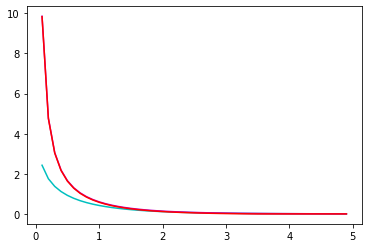

In [8]:
test_kn = torch.tensor(np.arange(0, 5, 0.1), device=device)
out_k0 = torch_scipy_k0(test_kn)
out_k1 = torch_scipy_k1(test_kn)
out_k1_cutoff = torch_scipy_k1_cutoff(test_kn)
fig, ax = plt.subplots()
ax.plot(test_kn.cpu(), out_k0.cpu(), 'c-')
ax.plot(test_kn.cpu(), out_k1.cpu(), 'm-')
ax.plot(test_kn.cpu(), out_k1_cutoff.cpu(), 'r-')

In [9]:
print(test_kn)
print(out_k0)
print(out_k1)
print(k1_cutoff)
print(out_k1_cutoff)

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000, 1.1000, 1.2000, 1.3000, 1.4000, 1.5000, 1.6000, 1.7000,
        1.8000, 1.9000, 2.0000, 2.1000, 2.2000, 2.3000, 2.4000, 2.5000, 2.6000,
        2.7000, 2.8000, 2.9000, 3.0000, 3.1000, 3.2000, 3.3000, 3.4000, 3.5000,
        3.6000, 3.7000, 3.8000, 3.9000, 4.0000, 4.1000, 4.2000, 4.3000, 4.4000,
        4.5000, 4.6000, 4.7000, 4.8000, 4.9000], device='cuda:0',
       dtype=torch.float64)
tensor([   inf, 2.4271, 1.7527, 1.3725, 1.1145, 0.9244, 0.7775, 0.6605, 0.5653,
        0.4867, 0.4210, 0.3656, 0.3185, 0.2782, 0.2437, 0.2138, 0.1880, 0.1655,
        0.1459, 0.1288, 0.1139, 0.1008, 0.0893, 0.0791, 0.0702, 0.0623, 0.0554,
        0.0493, 0.0438, 0.0390, 0.0347, 0.0310, 0.0276, 0.0246, 0.0220, 0.0196,
        0.0175, 0.0156, 0.0140, 0.0125, 0.0112, 0.0100, 0.0089, 0.0080, 0.0071,
        0.0064, 0.0057, 0.0051, 0.0046, 0.0041], device='cuda:0',
       dtype=torch.float64)
tensor([    

In [10]:
def J_chemMacdonald(xy, d): # cutoff! --> shift the values
    chemMag = torch_scipy_k1_cutoff(kappa * d) *(kappa/(2*np.pi))
    xy = chemMag * xy
    return torch.nansum(xy, dim=0, keepdim=False)    

In [11]:
if periodic:
    def xy2distance(xy, L):
        dx = xy[:, :1] - xy[:, :1].T   # neighbor - target
        dy = xy[:, 1:] - xy[:, 1:].T
        dx = dx % L
        dy = dy % L
        dx[dx > L/2] = dx[dx > L/2] - L
        dy[dy > L/2] = dy[dy > L/2] - L
        return [dx, dy]
else:
    def xy2distance(xy, L):
        dx = xy[:, :1] - xy[:, :1].T
        dy = xy[:, 1:] - xy[:, 1:].T
        return [dx, dy]    

def J_CF(xy, dr, q):
    c = torch.unsqueeze(q[0], 1)   # cos, sin of neighbor
    s = torch.unsqueeze(q[1], 1)
    xy = (1 + xy[:,:,:1] * c + xy[:,:,1:] * s) * xy / 2
    return torch.nansum(xy, dim=0, keepdim=False)

def J_CIL(xy, d, r):
    xy = ((r/d) - 1) * xy
    return torch.nansum(xy, dim=0, keepdim=False)

In [12]:
class SDE(torch.nn.Module):
    noise_type = 'scalar'
    sde_type = 'ito' if isIto else 'stratonovich'

    def __init__(self, L, periodic, v0, beta, A_CF, A_CIL, r, A, D):
        super().__init__()
        self.L = L
        self.periodic = periodic
        self.v0 = v0
        self.beta = beta
        self.A_CF = A_CF
        self.A_CIL = A_CIL
        self.r = r
        self.A = A

        self.sigma = torch.zeros((batch_size, state_size, 1), device=device)
        self.sigma[:, 2, 0] = np.sqrt(2*D)
        
    # Drift
    def f(self, t, y):
#        print(y.shape)
        xy = y[:, :2]
#        if self.periodic:
#            xy = xy % L
        xy = xy2distance(xy, self.L)
#        print(np.shape(xy))
#        print(xy[0].shape)
        xy = torch.cat((torch.unsqueeze(xy[0], 2), torch.unsqueeze(xy[1], 2)), 2)
        d = torch.norm(xy, p='fro', dim=2, keepdim=True)   # distance
        dr = torch.heaviside(self.r - d, torch.tensor([0.0], device=device))   # 1 if distance < r, else 0
        xy = dr * torch.nn.functional.normalize(xy, p=2.0, dim=2)   # normalized distance vector
        c = torch.cos(y[:, 2:])
        s = torch.sin(y[:, 2:])

        jcil = J_CIL(xy, d, self.r)
        
        jchem = J_chemMacdonald(xy, d)
        
        dx0 = self.v0 * torch.cat((c, s), 1)
        dx1 = -self.beta * jcil
        dtheta0 = self.A_CF * J_CF(xy, dr, [c,s]) - self.A_CIL * jcil
        dtheta0 = c * dtheta0[:, 1:] - s * dtheta0[:, :1]
        dtheta1 = self.A * c
        dtheta2 = A_Macdonald * (c * jchem[:, 1:] - s * jchem[:, :1])
        return torch.cat((dx0+dx1, dtheta0+dtheta1+dtheta2), 1)  # shape (batch_size, state_size)

    # Diffusion
    def g(self, t, y):
        return self.sigma


In [13]:
# Initial state y0, the SDE is solved over the interval [ts[0], ts[-1]].
# ys will have shape (t_size, batch_size, state_size)


y0 = torch.rand((batch_size, state_size), device=device)
y0 = torch.cat((y0[:,:2] * L, y0[:,2:] * (2*np.pi)), 1)

ts = torch.linspace(0, t_max, t_max+1, device=device)


# 

#y0 = torch.tensor([[4.0, 5.1, np.pi*0], [6.0, 4.9, np.pi*1.0]], device=device)
#y0 = torch.cat((y0[:,:2] * L, y0[:,2:] * (2*np.pi)), 1)

#ts = torch.linspace(0, 60, 3001, device=device)

#

bm = BrownianInterval(t0=ts[0], 
                      t1=ts[-1], 
                      size=(batch_size, brownian_size),
                      dt=stepSDE,
                      device=device)

In [14]:
print(ts)

tensor([   0.,    1.,    2.,  ...,  998.,  999., 1000.], device='cuda:0')


In [15]:
def testfun(x):
    x = torch.zeros((2,3), device=device)
    return x

x = torch.ones((2,3), device = device)
print(x)
testfun(x)
print(x)

tensor([[1., 1., 1.],
        [1., 1., 1.]], device='cuda:0')
tensor([[1., 1., 1.],
        [1., 1., 1.]], device='cuda:0')


In [16]:
sde = SDE(L, periodic, v0, beta, A_CF, A_CIL, r, A, D)

ys = sdeint(sde, y0, ts, bm=bm, dt=stepSDE, method=methodSDE)

In [17]:
cm = plt.cm.hsv

@interact(t_plot=(0, ts.size()[0]-1))
def f(t_plot):

  x = ys[t_plot,:,0].cpu().detach().numpy() % L
  y = ys[t_plot,:,1].cpu().detach().numpy() % L
  theta = ys[t_plot,:,2].cpu().detach().numpy() % (2*np.pi)

  fig, ax = plt.subplots()
  plt.title("polarity t = " + str(ts[t_plot].cpu().detach().numpy()))
  ax.set_aspect('equal')
  im = ax.quiver(x, y, np.cos(theta), np.sin(theta), theta, cmap=cm, scale = 1,scale_units='xy', pivot='mid')
  plt.xlim(0, L)
  plt.ylim(0, L)
  fig.colorbar(im)
  im.set_clim(0, 2*np.pi)


interactive(children=(IntSlider(value=500, description='t_plot', max=1000), Output()), _dom_classes=('widget-i…

In [18]:
print(ys.shape)

torch.Size([1001, 400, 3])


In [19]:
import datetime
import os
import codecs

now = datetime.datetime.now()
savedir = './HiraiwaModel_chem' + now.strftime('%Y%m%d_%H%M%S')
os.makedirs(savedir, exist_ok=True)

np.savez(os.path.join(savedir, 'params.npz'),
         v0 = v0, r = r, D = D, A = A, L = L,
         rho = rho, beta = beta, A_CF = A_CF, A_CIL = A_CIL, 
         kappa = kappa, A_Macdonald = A_Macdonald,
         batch_size = batch_size, state_size = state_size, brownian_size = brownian_size,
         periodic = periodic, t_max = t_max, methodSDE = methodSDE, isIto = isIto, stepSDE = stepSDE)

loaddir = savedir
params = np.load(loaddir+'/params.npz', allow_pickle=True)

txtstring = []
for k in params.files:
    txtstring.append("{} = {}".format(k, params[k]))

print(*txtstring, sep="\n", file=codecs.open(loaddir+'/params.txt', 'w', 'utf-8'))

In [20]:
plt.rcParams['figure.figsize'] = [12, 9]

cm = plt.cm.hsv

for t_plot in range(len(ts)):

  x = ys[t_plot,:,0].cpu().detach().numpy() % L
  y = ys[t_plot,:,1].cpu().detach().numpy() % L
  theta = ys[t_plot,:,2].cpu().detach().numpy() % (2*np.pi)

  fig, ax = plt.subplots()
  plt.title("polarity t = " + str(ts[t_plot].cpu().detach().numpy()))
  ax.set_aspect('equal')
  im = ax.quiver(x, y, np.cos(theta), np.sin(theta), theta, cmap=cm, scale = 1,scale_units='xy', pivot='mid')
  plt.xlim(0, L)
  plt.ylim(0, L)
  fig.colorbar(im)
  im.set_clim(0, 2*np.pi)
  
  fig.savefig(os.path.join(savedir, format(t_plot, '03d'))+'.png', format='png')
    
  plt.clf()
  plt.close()


In [21]:
theta = ys[:,:,2].cpu().detach().numpy()
print(theta)

[[  1.9724518    0.64160824   4.6072593  ...   4.763943     3.499435
    4.339199  ]
 [  2.3369305    0.12947191   5.108216   ...   4.7573175    3.664174
    4.4752812 ]
 [  3.9652045   -0.20012255   5.607696   ...   4.1421194    2.6925037
    5.397455  ]
 ...
 [-12.348274     0.7168682   12.2068405  ...  -4.8367105    1.1174372
    8.025871  ]
 [-12.521996     1.3324001   12.047947   ...  -5.12228      0.6609651
    7.844425  ]
 [-12.839954     0.8497915   12.445976   ...  -5.4090047    1.3119683
    8.111735  ]]


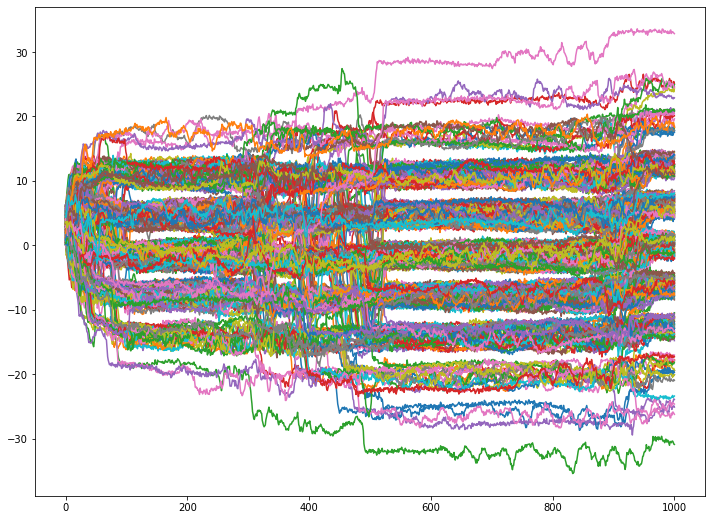

In [22]:
plt.plot(theta)

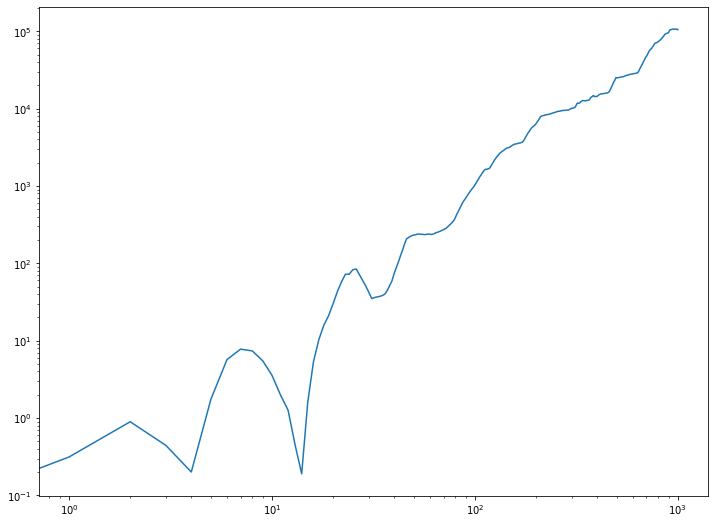

In [23]:
def MSD(ys):
    yy = ys - ys[0]
    msd0 = (yy**2).cpu().detach().numpy()
    return [np.sum(msd0[:, 0, :2], axis=1), msd0[:, 0, 2]]

msd1 = MSD(ys)[0]
plt.loglog(msd1)

In [24]:
spatialD = v0**2 / (2 * D)

In [25]:
plt.loglog(msd1[1:]/(4 * spatialD * np.arange(1,301)))

ValueError: operands could not be broadcast together with shapes (1000,) (300,) 